# DecisionTreeClassifier
© Thomas Robert Holy 2019
<br>
Version 1.0
<br><br>
Visit me on GitHub: https://github.com/trh0ly
<br>
Kaggle Link: https://www.kaggle.com/c/dda-p2/leaderboard

## Package Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime as dt
from IPython.core.display import display, HTML
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.svm import SVC 

## Hilfsfunktionen
### Funktion zur Betrachtung der Konfusinsmatrix

In [2]:
# Definition einer Funktion, welche eine Konfusionsmatrix und einen Klassifikationsreport
# zurückgibt. Die Konfusionsmatrix kann, wenn ein Wert für c gegeben ist, für beliebige 
# Werte von c betrachtet werden.
#------------
# Argumente:
# - X: DataFrame auf welchem die Prognose durchgefürt werden soll (ohne die Zielgröße)
# - y_true: Zum DataFrame X gehörige Werte der Zielgröße
# - model: Modell auf Basis dessen die Konfusionsmatrix berechnet werden soll
# - class_names: Bezeichnung für die Spalten des Dataframes (default=['0', '1'], mit 0 = negativ und 1 = positiv)
# - c:
# ---> Wenn None, dann wird die Konfusionsmatrix ohne die Einbeziehung von c bestimmt
# ---> Wenn != None, dann wird die Konfusionsmatrix in Abhängigkeit von c bestimmt
#------------

def get_confusion_matrix(X, y_true, model, class_names=['0', '1'], c=None):
    
    #----------------------------
    # Vorgelagerte Berechnung falls ein Wert für c gegeben ist
    # und die Konfusionsmatrix für ein gegebenes c anpasst
    if c != None:
        pred_probability = model.predict_proba(X)
        pred_probability = pred_probability >= c
        y_pred = pred_probability[:, 1].astype(int)
    
    #----------------------------
    # Wenn kein Wert für c gegeben, dann führe Prognose 
    # lediglich auf Basis des Modells durch
    if c == None:
        y_pred = model.predict(X)
    
    #----------------------------
    # Berechnet die Konfusionsmatrix
    conf_mat = confusion_matrix(y_true, y_pred)
    
    #----------------------------
    # Überführung in einen DataFrame für eine bessere Übersichtlichkeit
    df_index = pd.MultiIndex.from_tuples([('Wahrer Wert', cn) for cn in class_names])
    df_cols = pd.MultiIndex.from_tuples([('Prognose des Modells', cn) for cn in class_names])
    df_conf_mat = pd.DataFrame(conf_mat, index=df_index, columns=df_cols)

    return df_conf_mat, classification_report(y_true, y_pred)

### Funktion zur Betrachtung der ROC-Kurve

In [3]:
# Definition einer Funktion, welche auf Basis eines gegeben Modells und zweier zusammengehöriger
# DataFrames die receiver operating characteristic curve (ROC-Curve) visualisiert
#------------
# Argumente:
# - X: DataFrame auf welchem die Prognose durchgefürt werden soll (ohne die Zielgröße)
# - y_true: Zum DataFrame X gehörige Werte der Zielgröße
# - model: Modell auf Basis dessen die ROC-Curve berechnet werden soll
#------------

def roc_curve_func(X, y_true, model):    
        
        #----------------------------
        # Berechnung FPR, TPR und AUC auf Basis des Modells  
        y_score = model.predict_proba(X)[:,1]            
        FPR, TPR, _ = roc_curve(y_true, y_score)
        AUC = auc(FPR, TPR)            
            
        #----------------------------
        # Darstellung als Grafik
        plt.figure()
        plt.plot(FPR, TPR, color='red', lw=2, label='ROC-Kurve (AUC = %0.5f)' % AUC)
        plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-Kurve')
        plt.legend(loc="lower right")
        plt.show()

### Funktion für das Submitten

In [4]:
# Definition einer Funktion, welche das Submitten der Prognose auf dem Testdatensatz erleichert
#------------
# Argumente:
# - model: Modell auf Basis dessen die Prognose erfolgt
# - c:
# ---> Wenn None, dann wird die Prognose ohne die Berücksichtung von c vorgenommen
# ---> Wenn != None, dann wird Prognose mit der Berücksichtung von c vorgenommen
# - save:
# ---> Wenn False, dann werden die prognostizierten Daten nicht gespeichert
# ---> Wenn True, dann werden die prognostizierten Daten als .csv gespeichert
# - manu_name:
# ---> Wenn None, dann wird ein nicht eindeutiger Standardname als Bezeichnung der .csv gewählt
# ---> Wenn != None, dann wird die zu speichernde .csv mit einem timestamp versehen
#------------

def submit(model, c=None, save=False, manu_name=False):
    
    #--------------------------------
    # Testdatensatz einlesen
    X_test = pd.read_csv('test.csv', index_col=0)    
    
    #--------------------------------
    # Prognosewerte auf Sensordaten des Testdatensatzes und unter
    # Berücksichtung von c erzeugen
    if c != None:
        predicted_test = (model.predict_proba(X_test) >= c)[:,1].astype(int)
    
    #--------------------------------
    # Prognosewerte auf Sensordaten des Testdatensatzes erzeugen
    # ohne c zu Berücksichtigen
    if c == None:
        predicted_test = model.predict(X_test)
        
    #--------------------------------
    # Submissiondatensatz einlesen und prognostizierte Werte hineinschreiben
    submission = pd.read_csv('sample_submission.csv')
    submission['Fehlerhaft'] = predicted_test
    
    #--------------------------------
    # In .csv speichern, wenn save=True
    if save == True:
        
        #--------------------------------
        # Standardnamen wählen, wenn manu_name == False
        if manu_name == False:
            submission.to_csv('./predicted_values.csv', index=False)
            
        #--------------------------------
        # Standardnamen mit timestamp kombinieren, wenn  manu_name == True
        if manu_name == True:            
            import datetime 
            now = datetime.datetime.now()
            name = now.strftime('%Y-%m-%dT%H%M%S') + ('-%02d' % (now.microsecond / 10000))            
            submission.to_csv('./predicted_values_' + str(name) + '.csv', index=False)            
        
    return submission.head(), submission.loc[submission['Fehlerhaft'] == 1]

### Funktion zum Filtern von Quantilen

In [5]:
# Definition einer Funktion, welche einen gegeben DataFrame 
# um untere und obere Quantile beschneiden kann
#------------
# Argumente:
# - orignal_df: DataFrame welcher bearbeitet werden soll
# - quantile_low: Unteres Quantil bis zu welchem orignal_df beschnitten werden soll
# - quantile_high: Oberes Quantil welchem orignal_df beschnitten werden soll
# - colum_to_drop: Spalte des orignal_df, welche während des Vorgangs gedroppt werden soll
#------------

def filter_my_df(orignal_df, quantile_low, quantile_high, colum_to_drop):

    #----------------------------
    # Spalte "colum_to_drop" aus dem Datensatz entfernen
    df_filtered = orignal_df.loc[:, orignal_df.columns != colum_to_drop] 
    # Quantil-DataFrame erzeugen
    quant_df = df_filtered.quantile([quantile_low, quantile_high]) 
    # Quantil-DataFrame auf orignal_df anweden
    df_filtered = df_filtered.apply(lambda x: x[(x>quant_df.loc[quantile_low,x.name]) & 
                                                (x < quant_df.loc[quantile_high,x.name])],
                                                axis=0)
    #----------------------------
    # Spalte "Fehlerhaft" dem gefiltertem DataFrame wieder anfügen
    df_filtered = pd.concat([orignal_df.loc[:,colum_to_drop], df_filtered], axis=1)
    # Aus Beschneidung resultierende NaN-Werte bereinigen
    df_filtered.dropna(inplace=True)
    
    return df_filtered

## Datensatz einlesen (bereinigigen) und betrachten
### Datensatz einlesen

In [6]:
#----------------------------
# Datensatz einlesen
data = pd.read_csv('train.csv', index_col=0)

### Optionale Datensatzbereinigung

In [7]:
"""
#----------------------------
# Datensatz unterteilen

df_fehlerfrei = data.loc[data['Fehlerhaft'] == 0]
df_fehlerhaft = data.loc[data['Fehlerhaft'] == 1]
"""

"""
#----------------------------
# Fehlerfreie Stückgüter
colum_to_drop = 'Fehlerhaft'
orignal_df = df_fehlerfrei
low = .0 # Unteres Quantil 
high = .99 # Oberes Quantil
df_fehlerfrei_filtered = filter_my_df(df_fehlerfrei, low, high, colum_to_drop)

#----------------------------
# Fehlerhafte Stückgüter
colum_to_drop = 'Fehlerhaft'
orignal_df = df_fehlerhaft
low = .018333 # Unteres Quantil 
high = 1. # Oberes Quantil
df_fehlerhaft_filtered = filter_my_df(df_fehlerhaft, low, high, colum_to_drop)

#----------------------------
# Teil-DataFrames zusammenführen
data_filtered = pd.concat([df_fehlerhaft_filtered, df_fehlerfrei_filtered], sort=False)
"""

"\n#----------------------------\n# Fehlerfreie Stückgüter\ncolum_to_drop = 'Fehlerhaft'\norignal_df = df_fehlerfrei\nlow = .0 # Unteres Quantil \nhigh = .99 # Oberes Quantil\ndf_fehlerfrei_filtered = filter_my_df(df_fehlerfrei, low, high, colum_to_drop)\n\n#----------------------------\n# Fehlerhafte Stückgüter\ncolum_to_drop = 'Fehlerhaft'\norignal_df = df_fehlerhaft\nlow = .018333 # Unteres Quantil \nhigh = 1. # Oberes Quantil\ndf_fehlerhaft_filtered = filter_my_df(df_fehlerhaft, low, high, colum_to_drop)\n\n#----------------------------\n# Teil-DataFrames zusammenführen\ndata_filtered = pd.concat([df_fehlerhaft_filtered, df_fehlerfrei_filtered], sort=False)\n"

### Beschreibung der separierten Datensätze (Betrachtung Min-/ Maximum und Qunatile)

In [8]:
"""
df_fehlerfrei.describe()
"""

'\ndf_fehlerfrei.describe()\n'

In [9]:
"""
df_fehlerhaft.describe()
"""

'\ndf_fehlerhaft.describe()\n'

In [10]:
data_new = data #_filtered
data_new['Fehlerhaft'].value_counts()

0    20208
1      284
Name: Fehlerhaft, dtype: int64

### Betrachtung Korrelationsmatrix

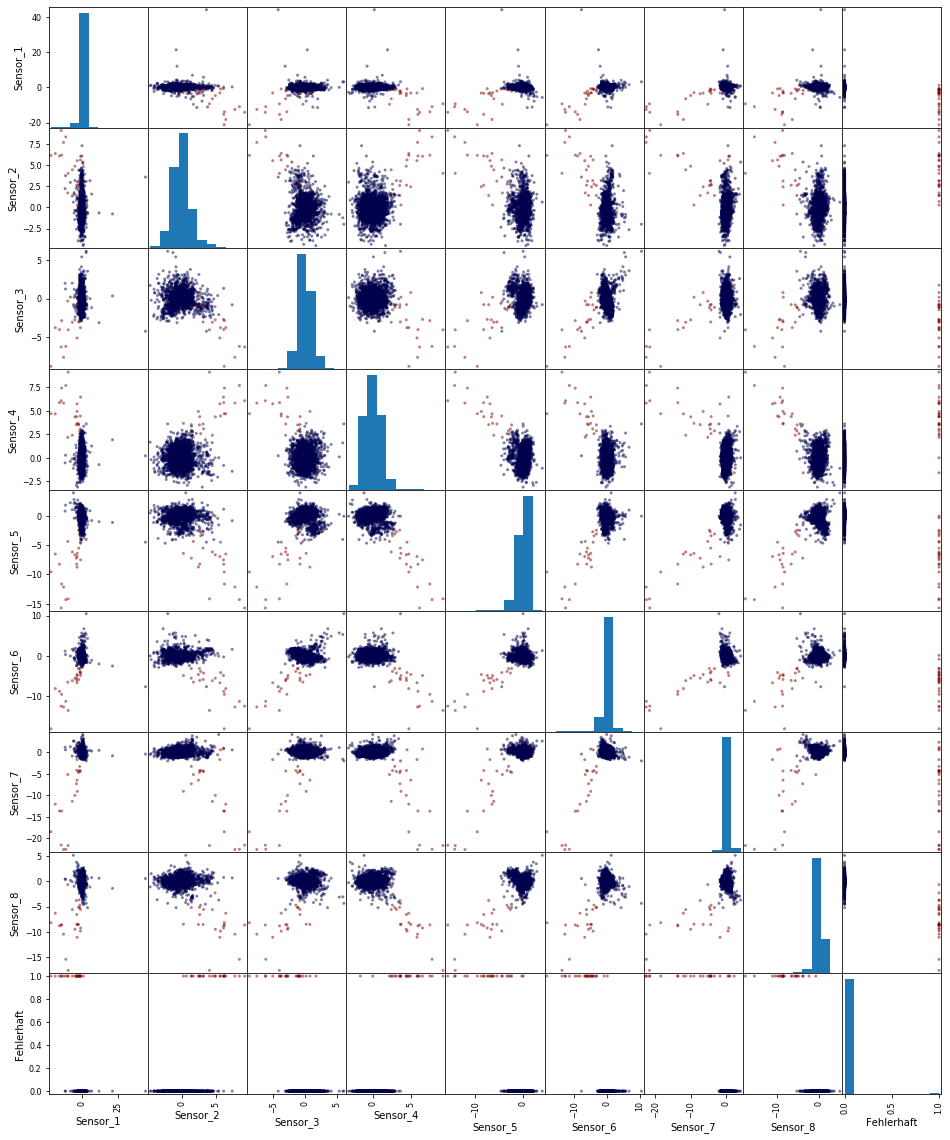

In [11]:
data_new = data #_filtered

#----------------------------
# Für schnellere Laufzeit und mehr Übersicht in den Plots: Stichprobe der Daten abbilden
data_sample = data_new.sample(2000, random_state=28)  # random_state sorgt für reproduzierbare Stichprobe, sodass die Stichprobe für uns alle identisch ist
_ = pd.plotting.scatter_matrix(data_sample, c=data_sample['Fehlerhaft'], cmap='seismic', figsize=(16, 20))

### Dateinsatz in Traings- und Validierungsteil splitten

In [12]:
X = data_new.drop('Fehlerhaft', axis=1)
y = data_new['Fehlerhaft']
X_train, X_validierung, y_train, y_validierung = train_test_split(X, y, test_size=0.2, random_state=2121)

## Modell aufstellen

In [13]:
# Definition einer Funktion, welche eine Gittersuche mit einem DecisionTreeClassifier durchführt
# und nach einer 5-fach Kreuzvalidierung das beste Modell zurückgibt
#------------
# Argumente:
# - i: Fügt X^i der Featurematrix hinzu
# - X: DataFrame auf welchem die Prognose durchgefürt werden soll (ohne die Zielgröße)
# - y_true: Zum DataFrame X gehörige Werte der Zielgröße
# - my_scaler: Zu verwendender Scaler; per default MinMaxScaler; weitere Scaler: RobustScaler, Standardscaler
# - C: Parameter für die Regularisierung; je kleiner, desto stärker die Regularisierung
# - max_features: Anzahl der Features die einbezogen werden sollen (default=['auto']=sqrt(n_features))
# - jobs: Anzahl der Threads die für den Durchlauf zur Verfügung stehen
# - gs_scoring: Scoring Verfahren im Rahmen der GridSearch 
# - folts: Komplexität der Kreuzvalidierung
#------------

def dt_1(i, X, y_true, my_scaler=MinMaxScaler, jobs=-3, gs_scoring='f1', folts=5, max_features=None):

    #--------------------------------
    # Pipeline erzeugen
    prediction_pipe = Pipeline([('scaler', my_scaler()), 
                                ('add_x_square', PolynomialFeatures(degree=i)),
                                ('classifier', DecisionTreeClassifier())])

    #--------------------------------
    # Parameter Grid
    param_grid = [{'classifier': [DecisionTreeClassifier()],
                   'classifier__max_features': [max_features],
                   'classifier__random_state': [2111]}
                  ]

    #--------------------------------
    # StratifiedKFold für unbalancierten Datensatz
    scv = StratifiedKFold(n_splits=folts)

    #--------------------------------
    # Gittersuche
    grid_search = GridSearchCV(
            estimator=prediction_pipe, 
            param_grid=param_grid,
            scoring=gs_scoring,
            cv=scv,
            verbose=True,
            n_jobs=jobs,
            iid=False)

    #--------------------------------
    # Fit
    model = grid_search.fit(X,y_true)

    return model, grid_search.best_score_

### Modelaufruf und Scoring
#### Modell 1

In [14]:

dt_model, dt_score = dt_1(1, X_train, y_train, my_scaler=MinMaxScaler, jobs=-3, gs_scoring='f1', folts=5, max_features=None)
dt_score


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:    1.3s finished


0.8343291872700128

#### Modell 2

In [15]:

dt_model2, dt_score2 = dt_1(1, X_train, y_train, my_scaler=StandardScaler, jobs=-3, gs_scoring='f1', folts=5, max_features=None)
dt_score


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:    1.0s finished


0.8343291872700128

In [16]:

dt_model3, dt_score3 = dt_1(1, X_train, y_train, my_scaler=RobustScaler, jobs=-3, gs_scoring='f1', folts=5, max_features=None)
dt_score3


[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-3)]: Done   5 out of   5 | elapsed:    0.0s finished


0.836113675945373

#### Scoring Model 1 / Modell 2

In [17]:

model = dt_model
print(model.best_params_)

model = dt_model2
print(model.best_params_)

model = dt_model3
print(model.best_params_)


{'classifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2111, splitter='best'), 'classifier__max_features': None, 'classifier__random_state': 2111}
{'classifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2111, splitter='best'), 'classifier__max_features': None, 'classifier__random_state': 2111}
{'classifier': Decisio

In [18]:

model = dt_model3
c = 0.35

class_names = ['Stückgut fehlerfrei', 'Stückgut fehlerhaft']
confusion_matrix1, report1 = get_confusion_matrix(X_train, y_train, model, class_names, c)
confusion_matrix1


Prognose des Modells                    
                                 Stückgut fehlerfrei Stückgut fehlerhaft
Wahrer Wert Stückgut fehlerfrei                16168                   0
            Stückgut fehlerhaft                    0                 225

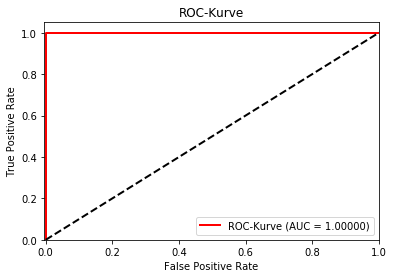

In [19]:

roc_curve_func(X_train, y_train, model)


In [20]:

print(report1)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16168
           1       1.00      1.00      1.00       225

    accuracy                           1.00     16393
   macro avg       1.00      1.00      1.00     16393
weighted avg       1.00      1.00      1.00     16393



#### Scoring auf Validerungsdatensatz

In [21]:

model = dt_model3
c = 0.35

class_names = ['Stückgut fehlerfrei', 'Stückgut fehlerhaft']
confusion_matrix2, report2 = get_confusion_matrix(X_validierung, y_validierung, model, class_names, c)
confusion_matrix2


Prognose des Modells                    
                                 Stückgut fehlerfrei Stückgut fehlerhaft
Wahrer Wert Stückgut fehlerfrei                 4032                   8
            Stückgut fehlerhaft                   14                  45

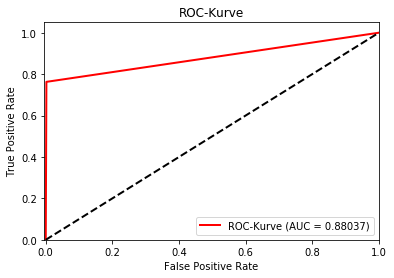

In [22]:

roc_curve_func(X_validierung, y_validierung, model)


In [23]:

print(report2)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4040
           1       0.85      0.76      0.80        59

    accuracy                           0.99      4099
   macro avg       0.92      0.88      0.90      4099
weighted avg       0.99      0.99      0.99      4099



## Submit
### Kontrolle Modellwahl (Modell 1 oder 2) anhand der Konfusionsmatrix

In [24]:
"""
model = dt_model3
c = 0.35

class_names = ['Stückgut fehlerfrei', 'Stückgut fehlerhaft']
confusion_matrix3, report3 = get_confusion_matrix(X_validierung, y_validierung, model, class_names, c)
confusion_matrix3
"""

"\nmodel = dt_model3\nc = 0.35\n\nclass_names = ['Stückgut fehlerfrei', 'Stückgut fehlerhaft']\nconfusion_matrix3, report3 = get_confusion_matrix(X_validierung, y_validierung, model, class_names, c)\nconfusion_matrix3\n"

### Submit der Prognose

In [25]:
"""
submission_head, submission_fehlerhaft = submit(model, c, save=True, manu_name=True)
submission_head
"""

'\nsubmission_head, submission_fehlerhaft = submit(model, c, save=True, manu_name=True)\nsubmission_head\n'

### Ausgabe DataFrame mit als defekt klassifizierten Stückgütern im Testdatensatz

In [26]:
"""
submission_fehlerhaft
"""

'\nsubmission_fehlerhaft\n'